<a href="https://colab.research.google.com/github/NagarPratham/Drug-Side-Effects-and-Medical-Condition-Analysis/blob/main/Drug_Side_Effects_and_Medical_Condition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Definition & Goals
Objective:

Predict drug effectiveness (rating) based on features like side effects, drug class, and medical condition.

Identify hidden patterns (e.g., which side effects are most severe).

Cluster similar drugs based on their properties.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from textblob import TextBlob  # For sentiment analysis on side effects

# Load data
df = pd.read_csv("drugs_side_effects_drugs_com.csv")

# Check structure
print(df.head())
print(df.isnull().sum())

        drug_name medical_condition  \
0     doxycycline              Acne   
1  spironolactone              Acne   
2     minocycline              Acne   
3        Accutane              Acne   
4     clindamycin              Acne   

                                        side_effects         generic_name  \
0  (hives, difficult breathing, swelling in your ...          doxycycline   
1  hives ; difficulty breathing; swelling of your...       spironolactone   
2  skin rash, fever, swollen glands, flu-like sym...          minocycline   
3  problems with your vision or hearing; muscle o...  isotretinoin (oral)   
4  hives ; difficult breathing; swelling of your ...  clindamycin topical   

                                        drug_classes  \
0         Miscellaneous antimalarials, Tetracyclines   
1  Aldosterone receptor antagonists, Potassium-sp...   
2                                      Tetracyclines   
3  Miscellaneous antineoplastics, Miscellaneous u...   
4       Topical acne a

**2. Handling Missing Data**

In [3]:
# Fill missing numerical values with median (better than mean for skewed data)
df['rating'].fillna(df['rating'].median(), inplace=True)
df['no_of_reviews'].fillna(0, inplace=True)

# Fill categorical missing values
df['side_effects'].fillna("Unknown", inplace=True)
df['drug_classes'].fillna("Unknown", inplace=True)

<ipython-input-3-04dedaaccad6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(df['rating'].median(), inplace=True)
<ipython-input-3-04dedaaccad6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

**2.1 Extract Side Effect Severity (NLP-Based)**

In [4]:
# Use sentiment analysis to score side effect severity
def get_side_effect_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # -1 (bad) to +1 (good)

df['side_effect_sentiment'] = df['side_effects'].apply(get_side_effect_sentiment)

**2.2 One-Hot Encode Categorical Variables**

In [14]:
# Convert drug classes into dummy variables
drug_class_dummies = df['drug_classes'].str.get_dummies(', ')
df = pd.concat([df, drug_class_dummies], axis=1)

# Encode medical conditions
le = LabelEncoder()
df['medical_condition_encoded'] = le.fit_transform(df['medical_condition'])

**3: Exploratory Data Analysis (EDA) with Advanced Visualizations**

**3.1 Side Effect Sentiment Distribution**

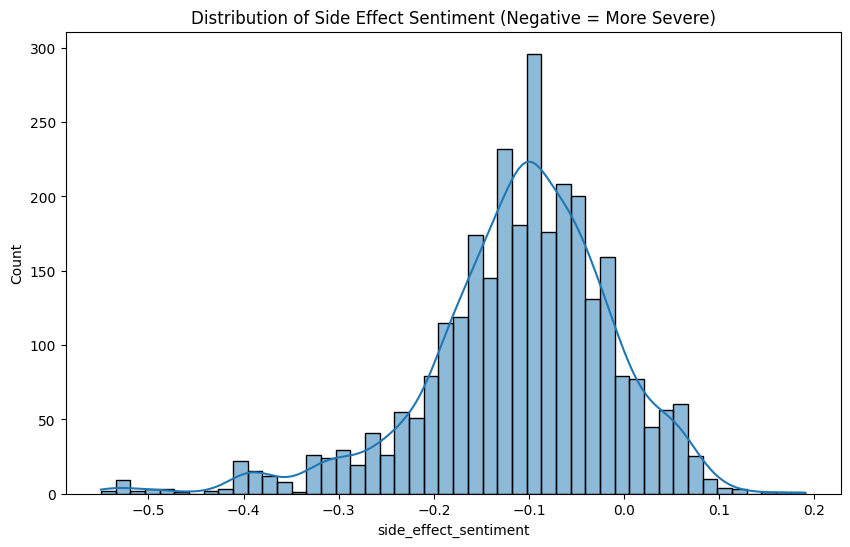

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['side_effect_sentiment'], kde=True)
plt.title("Distribution of Side Effect Sentiment (Negative = More Severe)")
plt.show()

**3.2 Top 10 Most Common Side Effects (Word Cloud)**

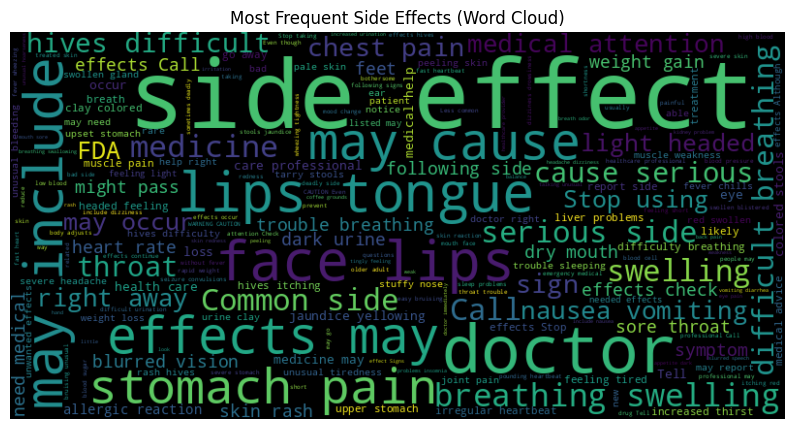

In [7]:
from wordcloud import WordCloud

side_effects_text = " ".join(df['side_effects'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(side_effects_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Side Effects (Word Cloud)")
plt.show()

**3.3 Drug Ratings vs. Side Effect Severity**

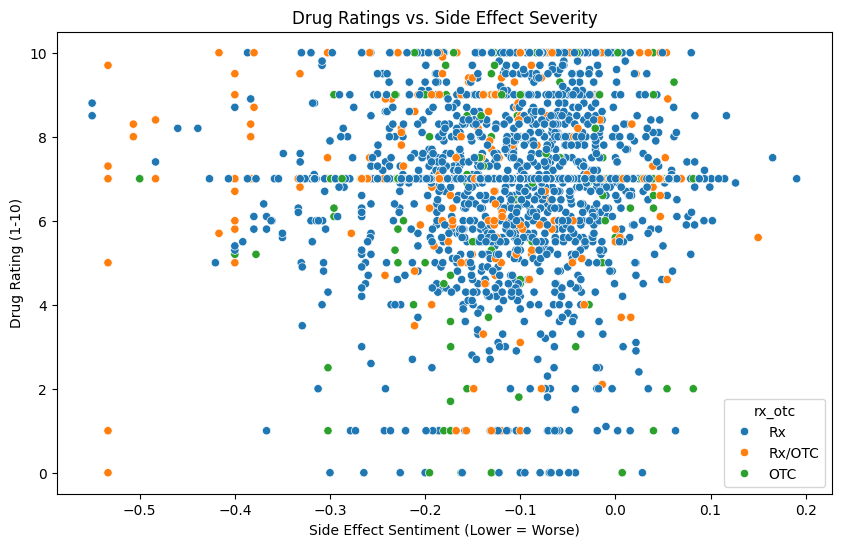

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='side_effect_sentiment', y='rating', data=df, hue='rx_otc')
plt.title("Drug Ratings vs. Side Effect Severity")
plt.xlabel("Side Effect Sentiment (Lower = Worse)")
plt.ylabel("Drug Rating (1-10)")
plt.show()

**4. Machine Learning for Drug Rating Prediction**

**4.1 Prepare Features & Target**

In [9]:
X = df[['side_effect_sentiment', 'medical_condition_encoded', 'no_of_reviews'] + list(drug_class_dummies.columns)]
y = df['rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**4.2 Train a Random Forest Regressor**

In [10]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
print("Train R²:", model.score(X_train, y_train))
print("Test R²:", model.score(X_test, y_test))

Train R²: 0.8505614152297974
Test R²: 0.2794135358166412


**4.3 Feature Importance**

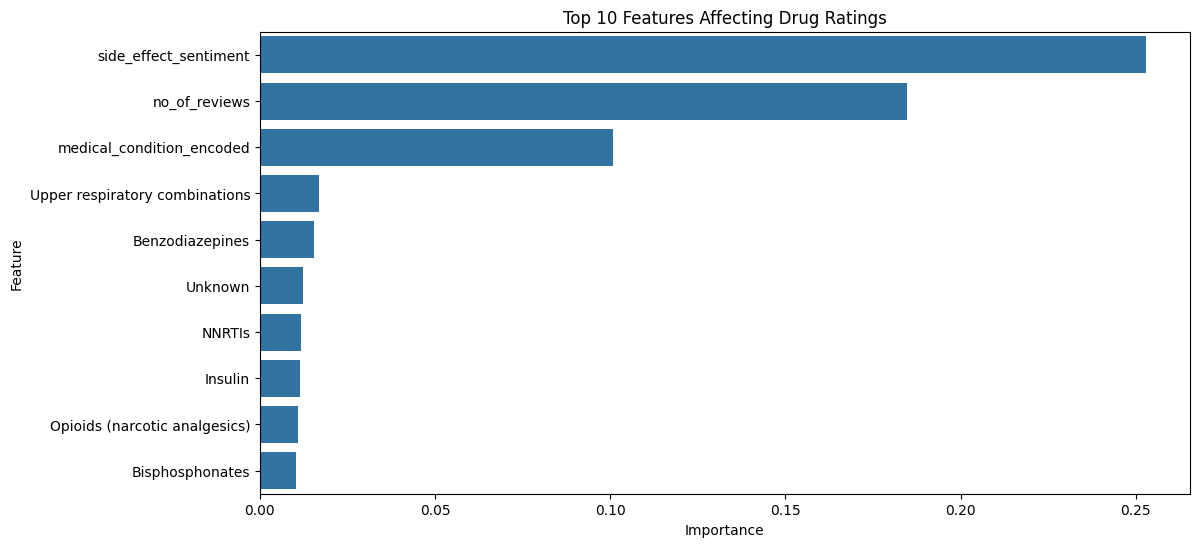

In [11]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title("Top 10 Features Affecting Drug Ratings")
plt.show()

**5. Clustering Drugs Based on Side Effects & Ratings**

**5.1 K-Means Clustering**

In [12]:
from sklearn.cluster import KMeans

# Select features for clustering
cluster_data = df[['rating', 'side_effect_sentiment', 'no_of_reviews']]

# Standardize
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_scaled)

**5.2 Visualize Clusters**

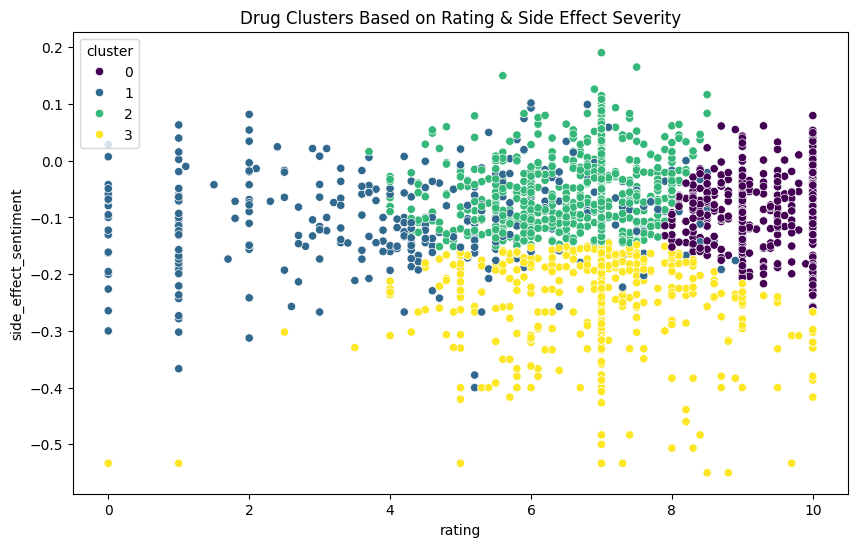

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='side_effect_sentiment', hue='cluster', data=df, palette='viridis')
plt.title("Drug Clusters Based on Rating & Side Effect Severity")
plt.show()